In [23]:
import pandas as pd
customers = pd.read_csv("../data/external/customers.csv", dtype=str)

customers.head()

,shopUserId,invoiceFirstName,invoiceLastName,invoiceSSN,invoiceZip,invoiceCity,invoiceCountryId,invoiceEmail
0,845840,Gun,Wirycz,194306227184,77634,Hedemora,205,wirycz.g@telia.com
1,879365,Siv Berit,Larsson,193602196424,67241,Töcksfors,205,1016-1757682914.fake@email.com
2,507462,Anette,Säker,196105288960,22658,Lund,205,govind.krishna.misra@gmail.com
3,879359,Monica,Fridlund,196206143049,91334,Holmsund,205,monfri62@outlook.com
4,79780,Tone Liv,Kjelingtveit,NaN,3864,Rauland,160,tonelivk@gmail.com


In [24]:

customers.isnull().mean()

shopUserId          0.000000
invoiceFirstName    0.000000
invoiceLastName     0.000000
invoiceSSN          0.360787
invoiceZip          0.000000
invoiceCity         0.000000
invoiceCountryId    0.000000
invoiceEmail        0.000000
dtype: float64

In [25]:
#count all rows
print(len(customers))

82406


In [26]:
# Output a sample of 10 invoiceSSN values and their counts
customers['invoiceSSN'].value_counts(dropna=False).head(10)


invoiceSSN
NaN             29731
temp             2316
195903311149       32
240343-4727        24
21034730684        20
030538-006Y        18
250962-1740        17
251153-1085        17
08076036447        16
180239-063A        16
Name: count, dtype: int64

In [27]:
# Display all rows where invoiceSSN is '141052-138Y'
from IPython.display import display
display(customers[customers['invoiceSSN'] == '15044437403'])


,shopUserId,invoiceFirstName,invoiceLastName,invoiceSSN,invoiceZip,invoiceCity,invoiceCountryId,invoiceEmail
13624,812880,Else Marie,Monsen,15044437403,2760,Brandbu,160,4037-1752651873.fake@email.com
21212,758448,Else Marie,Monsen,15044437403,2760,Brandbu,160,3695-1747732356.fake@email.com
24280,742757,Else Marie,Monsen,15044437403,2760,Brandbu,160,8396-1746691669.fake@email.com
25198,739610,Else Marie,Monsen,15044437403,2760,Brandbu,160,1833-1746521204.fake@email.com
41931,630646,Else Marie,Monsen,15044437403,2760,Brandbu,160,3621-1738928969.fake@email.com
56835,458194,Else Marie,Monsen,15044437403,2760,Brandbu,160,2032-1730454239.fake@email.com
62091,410369,Else Marie,Monsen,15044437403,2760,Brandbu,160,2828-1727951617.fake@email.com
73365,333261,Else Marie,Monsen,15044437403,2760,Brandbu,160,6541-1723106503.fake@email.com
75668,308458,Else Marie,Monsen,15044437403,2760,Brandbu,160,5947-1721283346.fake@email.com
76670,296247,Else Marie,Monsen,15044437403,2760,Brandbu,160,6459-1720169085.fake@email.com


## Different shopUserId are assigned to the same invoiceSSN -remap in both customers.csv and transactions.csv

In [28]:
# Map all rows with the same (invoiceFirstName, invoiceLastName, invoiceZip) to the first-seen shopUserId (canonical)
customers["_row"] = range(len(customers))
customers["name_zip_key"] = (
    customers["invoiceFirstName"].astype(str).str.strip() + "||" +
    customers["invoiceLastName"].astype(str).str.strip() + "||" +
    customers["invoiceZip"].astype(str).str.strip()
)

# Build mapping: canonical shopUserId per (name, zip)
canon_per_namezip = (
    customers.dropna(subset=["invoiceFirstName", "invoiceLastName", "invoiceZip"])
    .sort_values("_row")
    .groupby("name_zip_key", as_index=False)
    .agg(
        canonical_shopUserId=("shopUserId", "first"),
        shopUserIds_all_list=("shopUserId", lambda s: list(pd.unique(s))),
        n_ids=("shopUserId", pd.Series.nunique)
    )
)

# Save mapping
canon_per_namezip.assign(
    shopUserIds_all=canon_per_namezip["shopUserIds_all_list"].apply(lambda x: ",".join(map(str, x)))
)[["name_zip_key", "canonical_shopUserId", "n_ids", "shopUserIds_all"]].to_csv(
    "../data/processed/user_mapping_by_namezip.csv", index=False
)

# Remap shopUserId in customers, keep original in shopUserId_original, then drop it
customers["shopUserId_original"] = customers["shopUserId"]
customers = customers.merge(
    canon_per_namezip[["name_zip_key", "canonical_shopUserId"]],
    on="name_zip_key", how="left"
)
customers["shopUserId"] = customers["canonical_shopUserId"].fillna(customers["shopUserId"])
customers.drop(columns=["_row", "name_zip_key", "canonical_shopUserId", "shopUserId_original"], inplace=True)


In [29]:

# --- APPLY TO TRANSACTIONS 
# build flat remap from all old ids in each name+zip cluster to the canonical
remap = (
    canon_per_namezip.explode("shopUserIds_all_list")
                     .rename(columns={"shopUserIds_all_list": "shopUserId"})
                     [["shopUserId", "canonical_shopUserId", "name_zip_key"]]
                     .drop_duplicates()
)
remap.to_csv("../data/processed/shopUserId_remap.csv", index=False)

tx = pd.read_csv("../data/external/transactions.csv", dtype=str)
tx = tx.merge(remap[["shopUserId", "canonical_shopUserId"]], on="shopUserId", how="left")
tx["shopUserId"] = tx["canonical_shopUserId"].fillna(tx["shopUserId"])
tx.drop(columns=["canonical_shopUserId"], inplace=True)
tx.to_csv("../data/processed/transactions_canonical.csv", index=False)

In [30]:
# Deduplicate customers by shopUserId, keeping the first occurrence
customers = customers.drop_duplicates(subset=["shopUserId"], keep="first")


In [31]:
# Display all rows where invoiceSSN is '141052-138Y'
from IPython.display import display
display(customers[customers['invoiceSSN'] == '15044437403'])


,shopUserId,invoiceFirstName,invoiceLastName,invoiceSSN,invoiceZip,invoiceCity,invoiceCountryId,invoiceEmail
13624,812880,Else Marie,Monsen,15044437403,2760,Brandbu,160,4037-1752651873.fake@email.com


In [32]:
print(len(customers))

59867


In [33]:
customers.isnull().mean()

shopUserId          0.000000
invoiceFirstName    0.000000
invoiceLastName     0.000000
invoiceSSN          0.358779
invoiceZip          0.000000
invoiceCity         0.000000
invoiceCountryId    0.000000
invoiceEmail        0.000000
dtype: float64

In [34]:
# Drop all rows where any column contains the string 'temp'
mask = (customers.astype(str).apply(lambda col: col.str.contains('temp', na=False))).any(axis=1)
customers.drop(customers[mask].index, inplace=True)

In [35]:
print(len(customers))

57580


In [36]:
import re
from datetime import date

country_map = {"58": "DK", "160": "NO", "205": "SE", "72": "FI"}

def _safe_date(y, m, d):
    try:
        return date(int(y), int(m), int(d))
    except Exception:
        return None

def _age_from_birthdate(born):
    if not born:
        return None
    today = date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

def _parse_birthdate(ssn_str, country):
    if pd.isna(ssn_str):
        return None
    digits = re.sub(r'\D', '', str(ssn_str))

    if country == 'SE':
        if len(digits) >= 12:  # YYYYMMDDxxxx
            return _safe_date(digits[:4], digits[4:6], digits[6:8])
        elif len(digits) >= 10:  # YYMMDDxxxx
            yy, mm, dd = int(digits[:2]), digits[2:4], digits[4:6]
            sep = '-' if '-' in str(ssn_str) else '+' if '+' in str(ssn_str) else None
            this_year = date.today().year
            if sep == '+':  # 100+ years old
                y = 1900 + yy if (1900 + yy) <= this_year - 100 else 1800 + yy
            else:
                y = 1900 + yy if (1900 + yy) > this_year - 100 else 2000 + yy
            return _safe_date(y, mm, dd)
        return None

    if country == 'NO' and len(digits) == 11:
        dd, mm, yy = int(digits[0:2]), int(digits[2:4]), int(digits[4:6])
        individ = int(digits[6:9])
        if dd > 40:  # D-number adjustment
            dd -= 40
        if 0 <= individ <= 499:
            year = 1900 + yy
        elif 500 <= individ <= 749 and 54 <= yy <= 99:
            year = 1800 + yy
        elif 500 <= individ <= 999 and 0 <= yy <= 39:
            year = 2000 + yy
        elif 900 <= individ <= 999 and 40 <= yy <= 99:
            year = 1900 + yy
        else:
            year = (2000 + yy) if yy <= 24 else (1900 + yy)
        return _safe_date(year, mm, dd)

    if country == 'DK' and len(digits) >= 10:
        dd, mm, yy = digits[0:2], digits[2:4], int(digits[4:6])
        year = (2000 + yy) if yy <= 24 else (1900 + yy)
        return _safe_date(year, mm, dd)

    if country == 'FI':
        m = re.match(r'^(\d{2})(\d{2})(\d{2})([-+A])(\d{3})\w?$', str(ssn_str).strip(), re.I)
        if m:
            dd, mm, yy, cent = int(m.group(1)), int(m.group(2)), int(m.group(3)), m.group(4).upper()
            base = {'+': 1800, '-': 1900, 'A': 2000}[cent]
            return _safe_date(base + yy, mm, dd)
        if len(digits) >= 10:  # Old numeric-only fallback
            dd, mm, yy = int(digits[0:2]), int(digits[2:4]), int(digits[4:6])
            year = (2000 + yy) if yy <= 24 else (1900 + yy)
            return _safe_date(year, mm, dd)
        return None

    return None

def get_gender_age_from_ssn(ssn, country_id):
    if pd.isna(ssn):
        return None, None

    ssn_str = str(ssn).strip()
    country_id_str = str(country_id)
    country = country_map.get(country_id_str)
    if not country:
        return None, None

    digits = re.sub(r'\D', '', ssn_str)
    gender_digit = None
    if country == 'SE' and len(digits) >= 10:
        gender_digit = int(digits[-4:][2])
    elif country == 'NO' and len(digits) == 11:
        gender_digit = int(digits[8])
    elif country == 'DK' and len(digits) >= 10:
        gender_digit = int(digits[-1])
    elif country == 'FI':
        m = re.match(r'^\d{6}[-+A]\d{3}\w?$', ssn_str, re.I)
        if m:
            # In Finnish SSN, the gender digit is the 9th character (index 8 in digits)
            gender_digit = int(digits[8])
        elif len(digits) >= 10:
            gender_digit = int(digits[8])

    gender = None
    if gender_digit is not None:
        gender = 'Male' if gender_digit % 2 else 'Female'
    age = _age_from_birthdate(_parse_birthdate(ssn_str, country))
    return gender, age

# Apply to DataFrame
customers[['Gender', 'Age']] = customers.apply(
    lambda r: pd.Series(get_gender_age_from_ssn(r['invoiceSSN'], r['invoiceCountryId'])),
    axis=1
)


In [37]:
print(len(customers))

57580


In [38]:
# Keep customers where age is between 10 and 105, or where age is NaN
customers = customers[
    (customers['Age'].isna()) |
    ((customers['Age'] <= 105) & (customers['Age'] >= 10))
]


In [39]:
print(len(customers))

57577


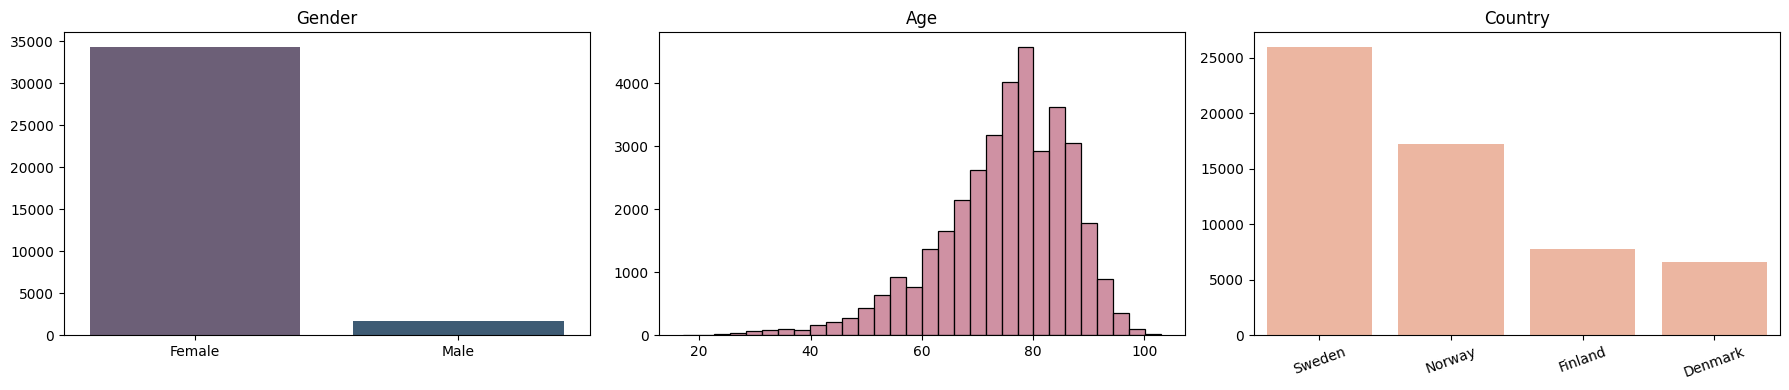

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure correct mapping and types
country_map = {58: 'Denmark', 205: 'Sweden', 160: 'Norway', 72: 'Finland'}
# invoiceCountryId is object, so map after converting to int where possible
def map_country(val):
    try:
        return country_map.get(int(val), val)
    except (ValueError, TypeError):
        return val

customers['Country'] = customers['invoiceCountryId'].apply(map_country).astype(str)

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# Gender plot
sns.countplot(
    data=customers,
    x='Gender',
    hue='Gender',
    palette=['#6C5B7B', '#355C7D'],
    ax=axes[0],
    order=['Female', 'Male'] if set(customers['Gender'].dropna()) == {'Female', 'Male'} else None,
    legend=False
)
axes[0].set(title='Gender', xlabel='', ylabel='')

# Age histogram
sns.histplot(
    customers['Age'].dropna().astype(float),
    bins=30,
    color='#C06C84',
    ax=axes[1]
)
axes[1].set(title='Age', xlabel='', ylabel='')

# Country plot
country_order = customers['Country'].value_counts().index
sns.countplot(
    x='Country',
    data=customers,
    order=country_order,
    color='#F8B195',
    ax=axes[2]
)
axes[2].set(title='Country', xlabel='', ylabel='')
axes[2].tick_params(axis='x', labelrotation=20)

plt.tight_layout()
plt.show()

In [41]:
print(len(customers))

57577


In [42]:
customers.astype(str).to_csv('../data/processed/customers_clean.csv', index=False)

In [22]:
customers.isna().sum()



shopUserId              0
invoiceFirstName        0
invoiceLastName         0
invoiceSSN          21477
invoiceZip              0
invoiceCity             0
invoiceCountryId        0
invoiceEmail            0
Gender              21477
Age                 21477
Country                 0
dtype: int64